In [1]:
import os
import pandas as pd
import numpy as np
import subprocess
import librosa
import IPython
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
wav_dir = 'wav_data'
feat_dir = 'features'
log_dir = 'logs'

if not os.path.exists(feat_dir):
    os.makedirs(feat_dir)
        
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

## Анализ разметки

In [3]:
data = pd.DataFrame(columns=['ID', 'Label', 'Length'])

for gender in ['f', 'm']:
        
    # Read and clean each label file
    df = pd.read_csv(f'{gender}.txt', header=None)
    df['ID'] = df[0].apply(lambda x: x.split('.')[0])
    df['Label'] = gender
    df = df.drop([0], axis=1).drop_duplicates()
    
    # accumulate labels in a single dataframe
    data = data.append(df, ignore_index=True)

### Проверка распределения данных по классам

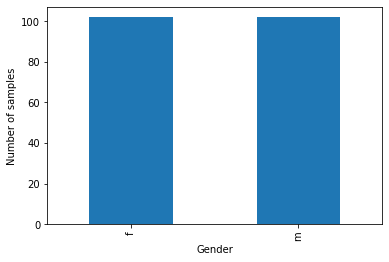

In [4]:
ax = data['Label'].value_counts().plot.bar()
ax.set_xlabel('Gender')
ax.set_ylabel('Number of samples')
plt.show()

Данные хорошо сбалансированы по классам 

### Проверка распределения длины аудио

In [5]:
data = data.set_index('ID')

for wav_name in os.listdir('wav_data'):
    wav_length = librosa.get_duration(filename=os.path.join(wav_dir, wav_name))
    data.at[wav_name.split('.')[0], 'Length'] = wav_length

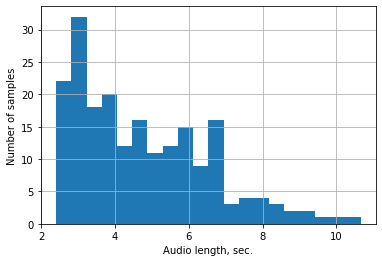

In [6]:
ax = data['Length'].hist(bins=20)
ax.set_xlabel('Audio length, sec.')
ax.set_ylabel('Number of samples')
plt.show()

В данных есть как очень короткие так и довольно длинные высказывания. 
Лучше проверить, чем длинные отличаются от коротких.
Возможно придется использовать VAD. 

In [7]:
data[data['Length'] > 10]

,Label,Length
ID,,
A30000L2,f,10.032
A30003S6,m,10.6565


In [8]:
IPython.display.Audio(os.path.join(wav_dir, 'A30003S6.wav'))

## Извлечение признаков OpenSMILE

In [9]:
for feature_type in ['IS10_paraling', 'IS11_speaker_state', 'IS12_speaker_trait', 'IS13_ComParE']:
    
    # Подготовим файлы для логов
    log_file = os.path.join(log_dir, f'log_{feature_type}.txt')
    with open(log_file, 'w') as handle:
        handle.write(f'\nExtracting {feature_type} features\n') 
    
    # Определяем конфигурацию OpenSMILE 
    smile_dir = r'C:\Users\User\opensmile230'
    smile = os.path.join(smile_dir, 'bin', 'Win32', 'SMILExtract_Release.exe')
    conf_file = os.path.join(smile_dir, 'config', feature_type + '.conf')
    
    print(f'Extracting {feature_type} features')
    for wav_name in tqdm(os.listdir('wav_data')):

        try:
            # Извлечение признаков для каждого аудиофайла 
            smile_call = [
                smile, 
                '-C', conf_file, 
                '-I', os.path.join(wav_dir, wav_name),
                '-csvoutput', os.path.join(feat_dir, feature_type + '.csv'), 
                '-instname', wav_name.split('.')[0], 
                '-timestampcsv 0']
            subprocess.run(smile_call)

        except:
            # Если opensmile рухнул записываем название файла в лог-файл 
            with open(log_file, 'a') as handle:
                handle.write(wav_name + '\n') 
                print(wav + ' failed\n')


  1%|▊                                                                                 | 2/204 [00:00<00:20,  9.75it/s]

Extracting IS10_paraling features


  1%|▊                                                                                 | 2/204 [00:00<00:14, 14.02it/s]

Extracting IS11_speaker_state features


  1%|▊                                                                                 | 2/204 [00:00<00:14, 13.83it/s]

Extracting IS12_speaker_trait features


  1%|▊                                                                                 | 2/204 [00:00<00:16, 12.15it/s]

Extracting IS13_ComParE features


100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:21<00:00,  9.28it/s]


## Подготовка данных к классификации

In [10]:
feature_type = 'IS10_paraling'
features = pd.read_csv(f'features/{feature_type}.csv', sep=';')
features = features.drop(['frameTime'], axis=1)
features['name'] = features['name'].apply(lambda x: x[1:-1])
features = features.rename({'name' : 'ID'}, axis=1)

# Merge features and labels to make sure that they are in the same order
data = data.merge(features, on='ID')
data

,ID,Label,Length,pcm_loudness_sma_maxPos,pcm_loudness_sma_minPos,pcm_loudness_sma_amean,pcm_loudness_sma_linregc1,pcm_loudness_sma_linregc2,pcm_loudness_sma_linregerrA,pcm_loudness_sma_linregerrQ,...,shimmerLocal_sma_de_quartile2,shimmerLocal_sma_de_quartile3,shimmerLocal_sma_de_iqr1-2,shimmerLocal_sma_de_iqr2-3,shimmerLocal_sma_de_iqr1-3,shimmerLocal_sma_de_percentile99.0,shimmerLocal_sma_de_upleveltime75,shimmerLocal_sma_de_upleveltime90,F0final__Turn_onsetRate,F0final__Turn_duration
0,A30000A1,f,3.053,71,39,0.283361,-0.001845,0.556404,0.259795,0.195361,...,-1.872874e-04,0.000001,0.000668,0.000188,0.000856,0.009718,0.818182,0.060606,1.337793,2.99
1,A30000A2,f,2.947875,80,40,0.235962,-0.001124,0.396095,0.198368,0.120088,...,-2.446813e-04,0.000019,0.001329,0.000264,0.001593,0.000311,0.800000,0.666667,0.694445,2.88
2,A30000A3,f,2.602875,77,142,0.297500,-0.001918,0.538194,0.249943,0.198797,...,3.593103e-05,0.000419,0.000486,0.000383,0.000869,0.005351,0.125000,0.062500,1.574803,2.54
3,A30000A4,f,3.650125,127,12,0.263938,-0.000495,0.352057,0.251496,0.179787,...,3.304817e-05,0.000160,0.000549,0.000127,0.000676,0.001570,0.930233,0.906977,1.114206,3.59
4,A30000A5,f,3.357625,119,12,0.260464,-0.000756,0.383655,0.247689,0.155891,...,-3.153849e-05,0.000193,0.000644,0.000224,0.000868,0.012399,0.046512,0.023256,0.911854,3.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,A30003X2,m,2.5975,54,175,0.334314,-0.003357,0.753975,0.266848,0.169594,...,-1.291331e-04,0.000685,0.000385,0.000814,0.001199,0.002381,0.952381,0.857143,1.185771,2.53
200,A30003X3,m,4.8745,61,122,0.321465,-0.001592,0.701909,0.290135,0.310775,...,-6.164819e-04,0.000463,0.000628,0.001080,0.001708,0.009346,0.025641,0.025641,1.663202,4.81
201,A30003X4,m,2.797,68,129,0.229743,-0.001277,0.402093,0.181716,0.098782,...,-1.343051e-03,0.009174,0.006533,0.010518,0.017051,0.028539,0.125000,0.125000,0.732601,2.73
202,A30003X5,m,4.205,118,143,0.218261,-0.000692,0.360464,0.144653,0.064082,...,-1.864595e-03,0.000233,0.001070,0.002098,0.003168,0.004642,0.347826,0.173913,0.966184,4.14


## Классификация

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import recall_score

Так как данные сбалансированные, по большому счету не важно, какую метрику использовать - точность или полноту. Мы будем использовать полноту классификации. 

In [12]:
test_ratio = 0.2
num_splits = int(1 / test_ratio)

# Перемешиваем данные (just for fun)
data = data.sample(frac=1, random_state=111)

X = np.array(data.drop(['ID', 'Label', 'Length'], axis=1))
y = np.array(data['Label'])

print('X shape: ', X.shape)
print('y shape: ', y.shape)
   
# Определяем классификаторы 
lr_solvers = ['newton-cg', 'lbfgs', 'liblinear']
svm_solvers = ['linear', 'poly', 'rbf', 'sigmoid']
solvers = svm_solvers + lr_solvers

# Здесь будут храниться результаты
scores_train = pd.DataFrame(columns=['Fold', 'Solver', 'C', 'UAR'])
scores_test = pd.DataFrame(columns=['Fold', 'Solver', 'C', 'UAR'])

print(f'\nTraining started. Checking {len(solvers)} classifiers')
for solver in tqdm(solvers):

    for i in np.around(np.arange(0.01, 1.01, 0.01), decimals=2):
    
        # Определяем разбиение данных для кроссвалидации
        skf = StratifiedKFold(n_splits=num_splits, random_state=0, shuffle=True)
        
        fold_counter = 1
        for train, test in skf.split(X, y):

            X_train = X[train]
            y_train = y[train]

            X_test = X[test]
            y_test = y[test]
            
            # Нормализация данных
            scaler = StandardScaler()
            scaler = scaler.fit(X[train])

            X_train = scaler.transform(X[train])
            X_test = scaler.transform(X[test])
            
            # Классификация
            if solver in svm_solvers:
                clf = SVC(C=i, kernel=solver, random_state=0).fit(X_train, y_train)
            elif solver in lr_solvers:
                clf = LogisticRegression(C=i, solver=solver, random_state=0, max_iter=1000).fit(X_train, y_train)
            
            # Сохранение результатов
            train_uar = np.around(recall_score(y_train, clf.predict(X_train), average='macro'), decimals=4)
            test_uar = np.around(recall_score(y_test, clf.predict(X_test), average='macro'), decimals=4)
            
            scores_train = scores_train.append({
                'Fold': fold_counter, 
                'Solver': solver, 
                'C': i, 
                'UAR': train_uar}, ignore_index=True)
            
            scores_test = scores_test.append({
                'Fold': fold_counter, 
                'Solver': solver, 
                'C': i, 
                'UAR': test_uar}, ignore_index=True)
            
            fold_counter += 1

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

X shape:  (204, 1582)
y shape:  (204,)

Training started. Checking 7 classifiers


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:39<00:00, 14.25s/it]


## Анализ результатов

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix

### Эффективность классификаторов на разных кросс-валидационных выборках 

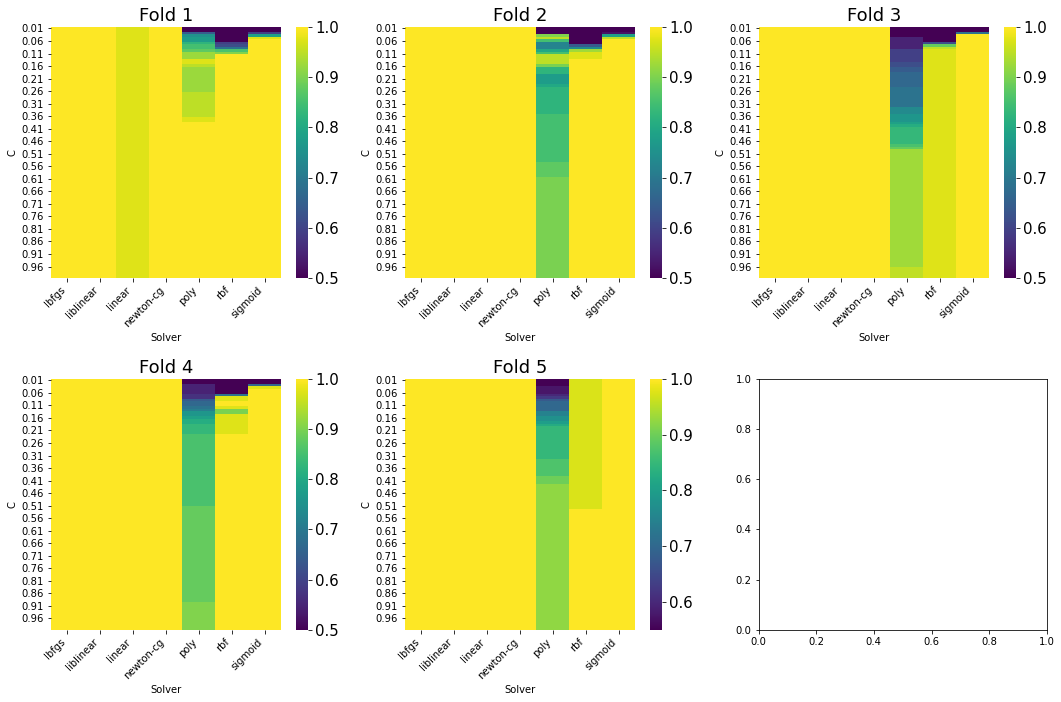

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.rcParams.update({'font.size': 15})

for group, group_data in scores_test.groupby('Fold'):
    
    group_data = group_data.pivot(index='C', columns='Solver', values='UAR')
    curr_ax = axes[(group-1)//3][(group+2)%3]
    sns.heatmap(data=group_data, cmap=sns.color_palette("viridis", as_cmap=True), ax=curr_ax)
    curr_ax.set_title(f'Fold {group}')
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()

### Средняя эффективность классификаторов на кросс-валидации

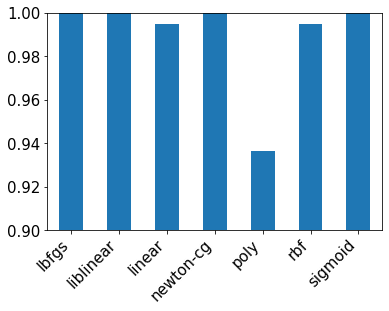

In [15]:
results = {}
for solver, solver_data in scores_test.groupby('Solver'):
    
    best_mean_cv = solver_data.groupby('C').mean()['UAR'].max()
    results[solver] = best_mean_cv
    
ax = pd.Series(results).plot.bar()
ax.set_ylim(0.9, 1)
ax.set_xticklabels(curr_ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

### Матрица спутывания и другие метрики для тестового набора наилучшего и наихудшего классификатора c последней кросс-валидационной выборки


poly (C=0.43)
              precision    recall  f1-score   support

           f       0.87      1.00      0.93        20
           m       1.00      0.85      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40


sigmoid (C=0.01)
              precision    recall  f1-score   support

           f       1.00      1.00      1.00        20
           m       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



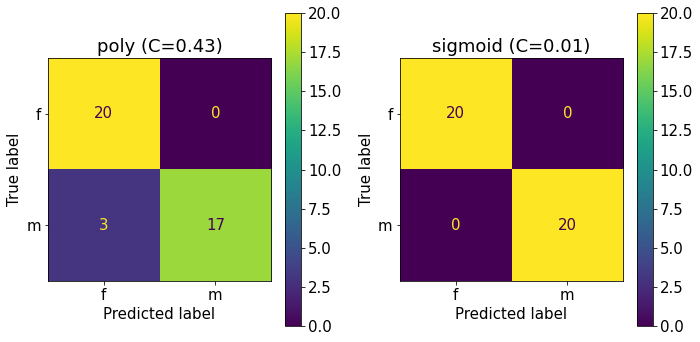

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for num_axis, solver in enumerate(['poly', 'sigmoid']):
    
    idx = scores_test[(scores_test['Solver'] == solver) & (scores_test['Fold'] == 5)]['UAR'].idxmax()
    C = scores_test.iloc[idx]['C']

    if solver in svm_solvers:
        clf = SVC(C=C, kernel=solver, random_state=0).fit(X_train, y_train)
    else:
        clf = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=1000).fit(X_train, y_train)

    plot_confusion_matrix(clf, X_test, y_test, ax = axes[num_axis])
    axes[num_axis].set_title(f'{solver} (C={C})')
    
    print(f'\n{solver} (C={C})')
    print(classification_report(y_test, clf.predict(X_test)))
    
plt.tight_layout()

### Кривая ROC-AUC

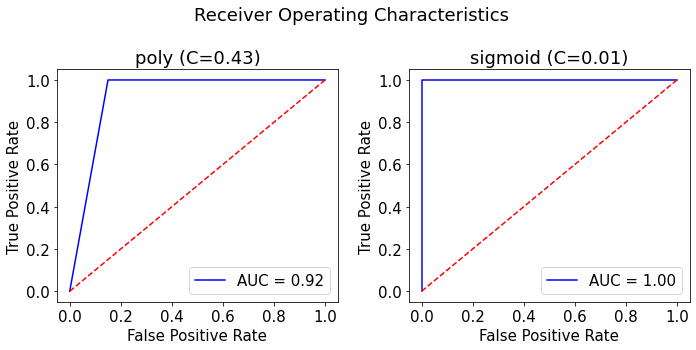

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Receiver Operating Characteristics')

for ax, solver in enumerate(['poly', 'sigmoid']):
    
    # Найдем наилучший классификатор
    idx = scores_test[(scores_test['Solver'] == solver) & (scores_test['Fold'] == 5)]['UAR'].idxmax()
    C = scores_test.iloc[idx]['C']
    if solver in svm_solvers:
        clf = SVC(C=C, kernel=solver, random_state=0).fit(X_train, y_train)
    else:
        clf = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=1000).fit(X_train, y_train)    
    preds = clf.predict(X_test)
    
    # По каким-то причинам roc_curve не работает с буквенными метками
    preds = [0 if p == 'm' else 1 for p in preds]
    labels = [0 if p == 'm' else 1 for p in y_test]
    
    fpr, tpr, threshold = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    
    axes[ax].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    axes[ax].legend(loc = 'lower right')
    axes[ax].plot([0, 1], [0, 1],'r--')
    axes[ax].set_ylabel('True Positive Rate')
    axes[ax].set_xlabel('False Positive Rate')
    axes[ax].set_title(f'{solver} (C={C})')
    
plt.tight_layout()